1. Importing all the required libraries

In [1]:
from Self_Library import *
from unet import *
import time
from torchvision import transforms
import nibabel as nib
from sklearn.model_selection import GridSearchCV,train_test_split
from skorch import NeuralNetRegressor
np.set_printoptions(threshold=np.inf)
from torch.optim.lr_scheduler import StepLR
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mod_unet import *
from natsort import natsorted
from torch.utils.tensorboard import SummaryWriter
import os



c:\Users\ifti03\Anaconda3\lib\site-packages\sigpy\config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
No module named 'cupyx.cudnn'
  warnings.warn(


2. Initialization of Model

In [4]:
class NewUnet_DS(nn.Module):
    """
    PyTorch implementation of a U-Net model.
    O. Ronneberger, P. Fischer, and Thomas Brox. U-net: Convolutional networks
    for biomedical image segmentation. In International Conference on Medical
    image computing and computer-assisted intervention, pages 234–241.
    Springer, 2015.
    """

    def __init__(self,in_chans: int,
                 out_chans: int,
                 chans: int = 64,
                 num_pool_layers: int = 4,
                 drop_prob: list = None,):
        """
        Args:
            in_chans: Number of channels in the input to the U-Net model.
            out_chans: Number of channels in the output to the U-Net model.
            chans: Number of output channels of the first convolution layer.
            num_pool_layers: Number of down-sampling and up-sampling layers.
            drop_prob: A list of dropout probab: len(drop_probs)=num_pool_layers+1
        """
        super().__init__()


        if drop_prob is None:
            drop_prob = [0.0] * num_pool_layers  # Default to no dropout if not specified
        elif len(drop_prob) != num_pool_layers+1:
            raise ValueError("drop_probs must have the same length as num_pool_layers")

        self.in_chans = in_chans
        self.out_chans = out_chans
        self.chans = chans
        self.num_pool_layers = num_pool_layers
        self.drop_prob = drop_prob

        self.down_sample_layers = nn.ModuleList([ConvBlock(in_chans, chans, drop_prob[0])])
        ch = chans
        for i in range(num_pool_layers-1):
            self.down_sample_layers.append(ConvBlock(ch, ch * 2, drop_prob[i+1]))
            ch *= 2
        self.conv = ConvBlock(ch, ch * 2, drop_prob[-1])

        self.up_conv = nn.ModuleList()
        self.up_transpose_conv = nn.ModuleList()
        for i in range(num_pool_layers - 1):
            self.up_transpose_conv.append(TransposeConvBlock(ch * 2, ch))
            self.up_conv.append(ConvBlock(ch * 2, ch, drop_prob[num_pool_layers - 1-i]))
            ch //= 2

        self.up_transpose_conv.append(TransposeConvBlock(ch * 2, ch))
        self.up_conv.append(
            nn.Sequential(
                ConvBlock(ch * 2, ch, drop_prob[0]),
                nn.Conv2d(ch, self.out_chans, kernel_size=1, stride=1),
            )
        )

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        """
        Args:
            image: Input 4D tensor of shape `(N, in_chans, H, W)`.
        Returns:
            Output tensor of shape `(N, out_chans, H, W)`.
        """
        stack = []
        output = image

        # apply down-sampling layers
        for layer in self.down_sample_layers:
            output = layer(output)
            stack.append(output)
            output = F.max_pool2d(output, kernel_size=2, stride=2, padding=0)
            # print("Downsampled output shape:", output.shape)

        output = self.conv(output)
        # print("After conv output shape:", output.shape)

        # apply up-sampling layers
        for transpose_conv, conv in zip(self.up_transpose_conv, self.up_conv):
            downsample_layer = stack.pop()
            output = transpose_conv(output)

            # reflect pad on the right/botton if needed to handle odd input dimensions
            padding = [0, 0, 0, 0]
            if output.shape[-1] != downsample_layer.shape[-1]:
                padding[1] = 1  # padding right
            if output.shape[-2] != downsample_layer.shape[-2]:
                padding[3] = 1  # padding bottom
            if torch.sum(torch.tensor(padding)) != 0:
                output = F.pad(output, padding, "reflect")

            output = torch.cat([output, downsample_layer], dim=1)
            output = conv(output)

        return output

3. Clearing the cache in the GPU

In [8]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

4. Inference on Representative Slices

Processing file 51: 51.nii and 51.mat


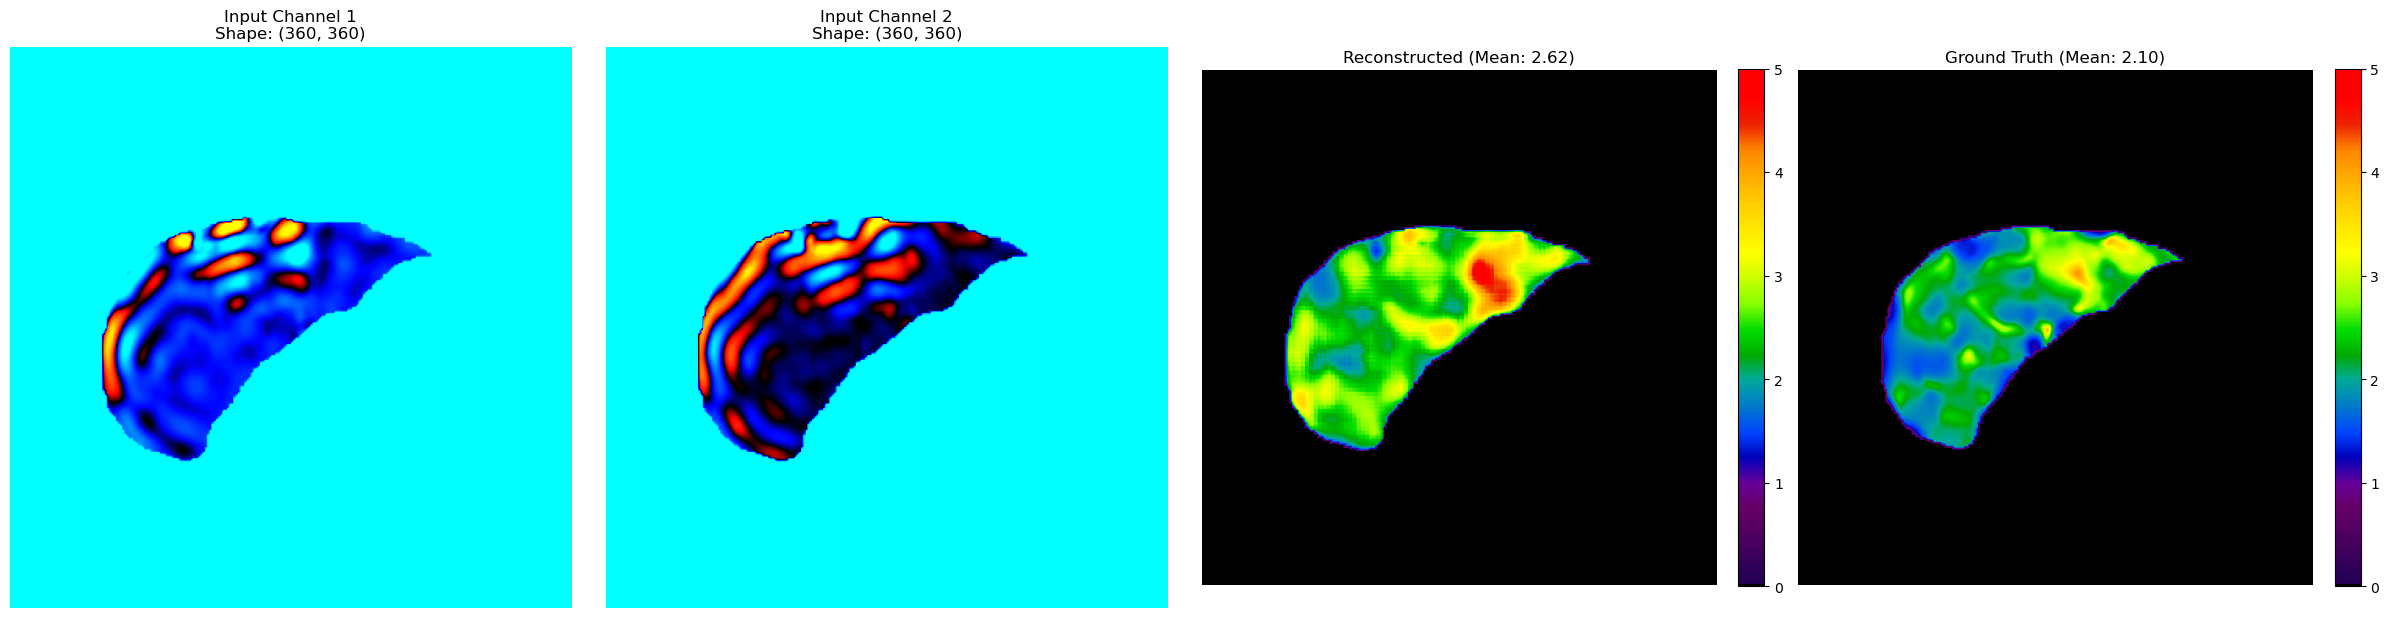

Processing file 52: 52.nii and 52.mat


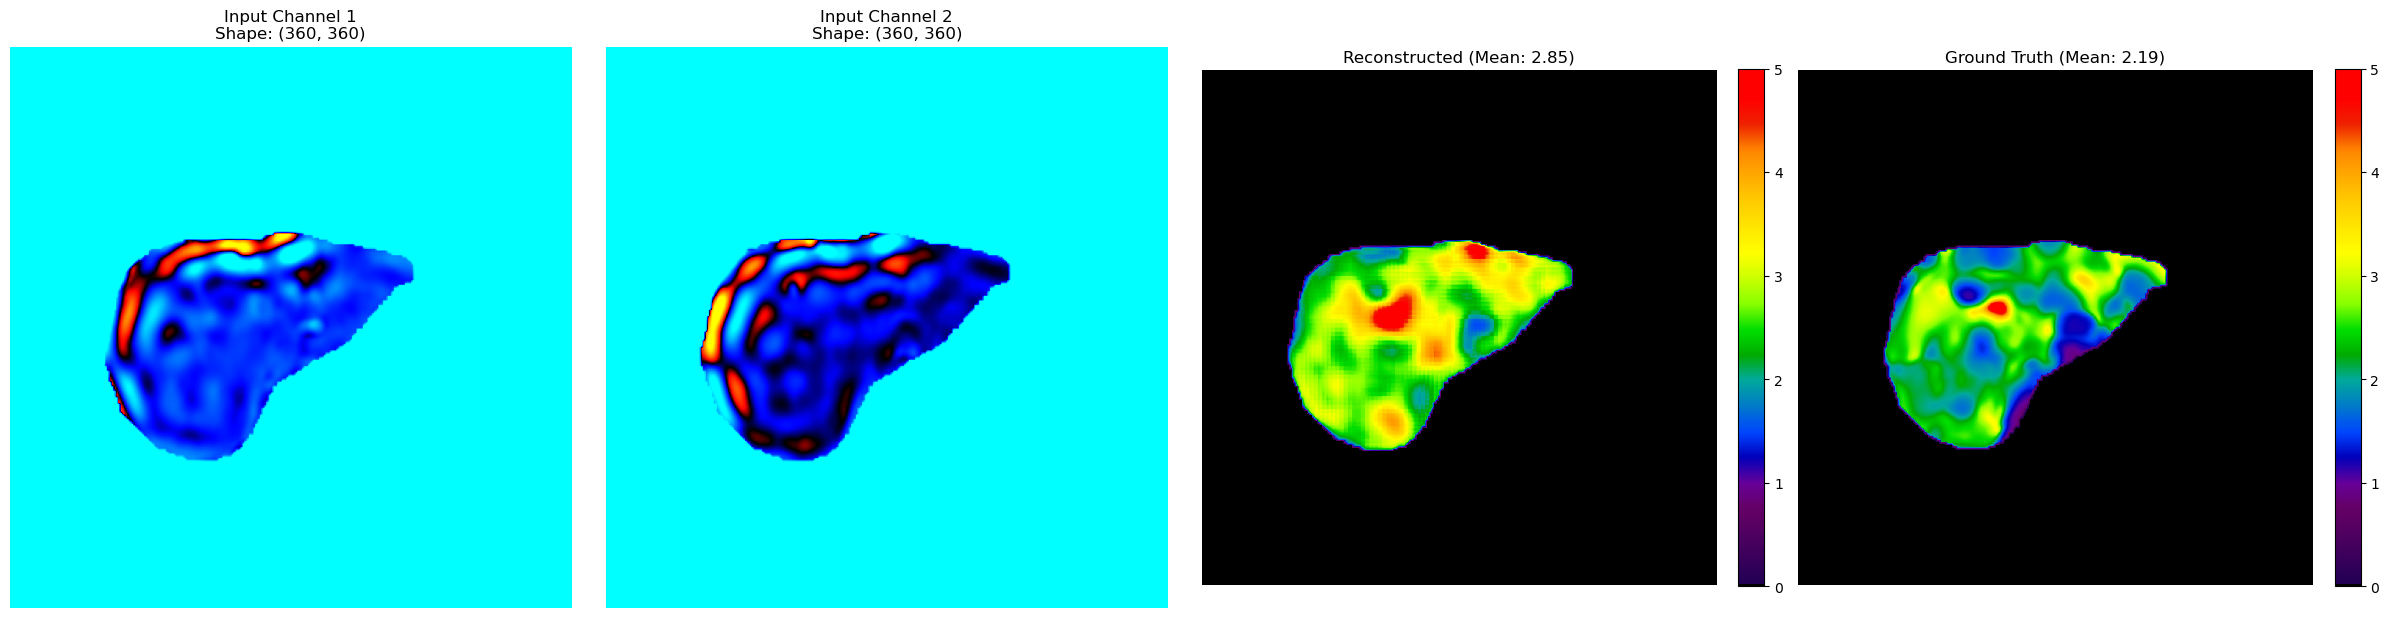

Processing file 53: 53.nii and 53.mat


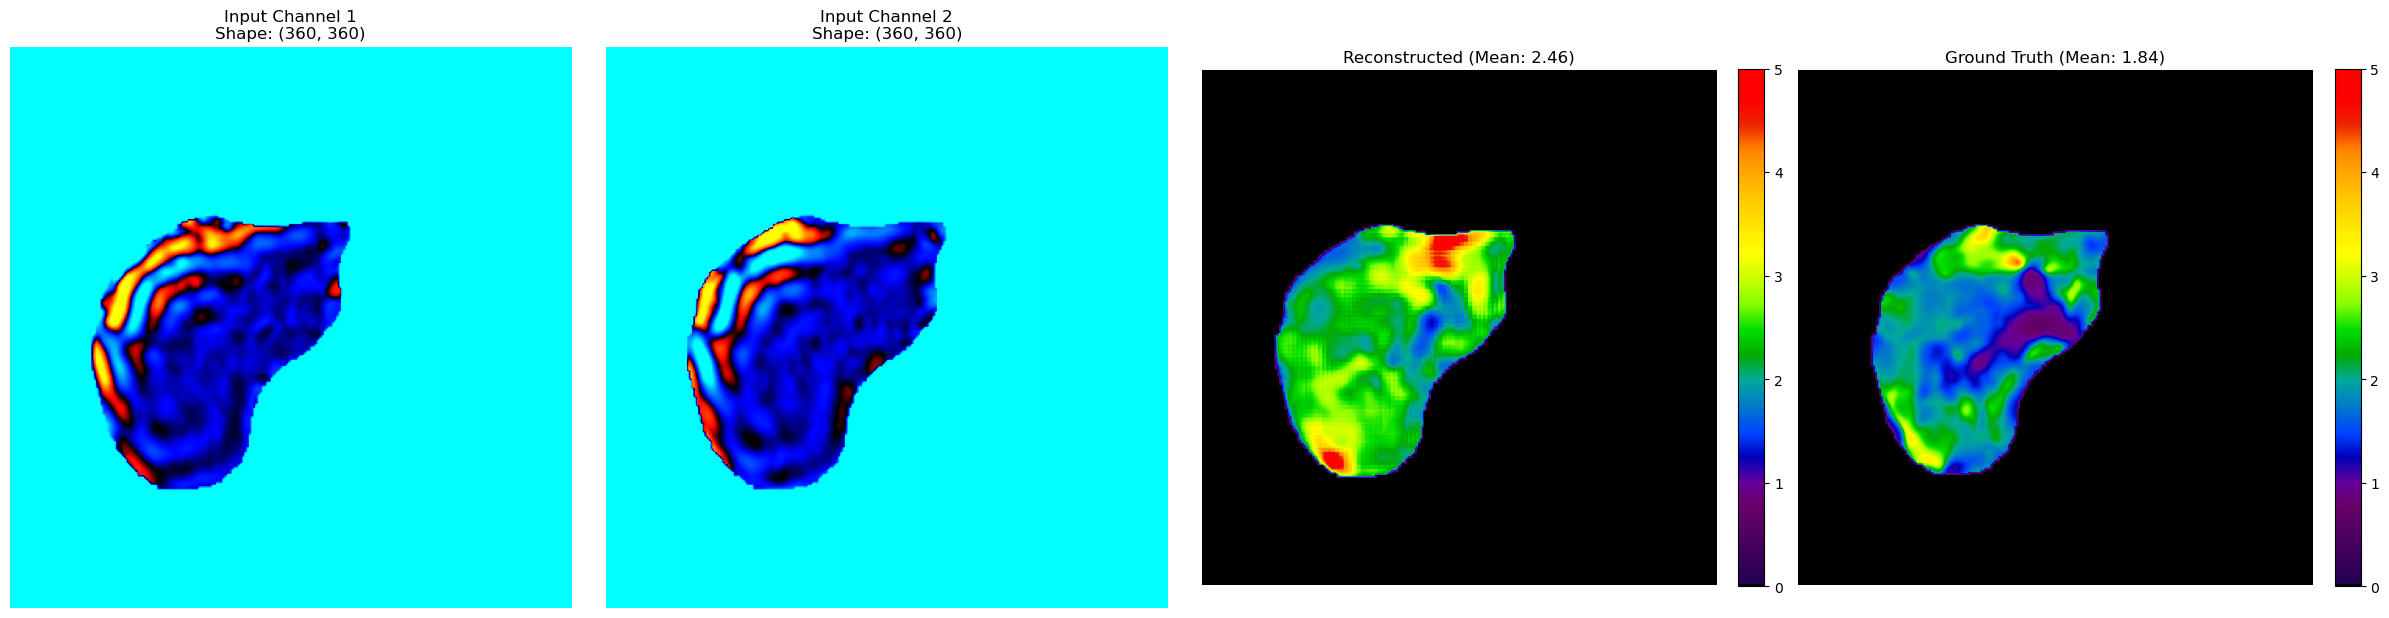

Processing file 54: 54.nii and 54.mat


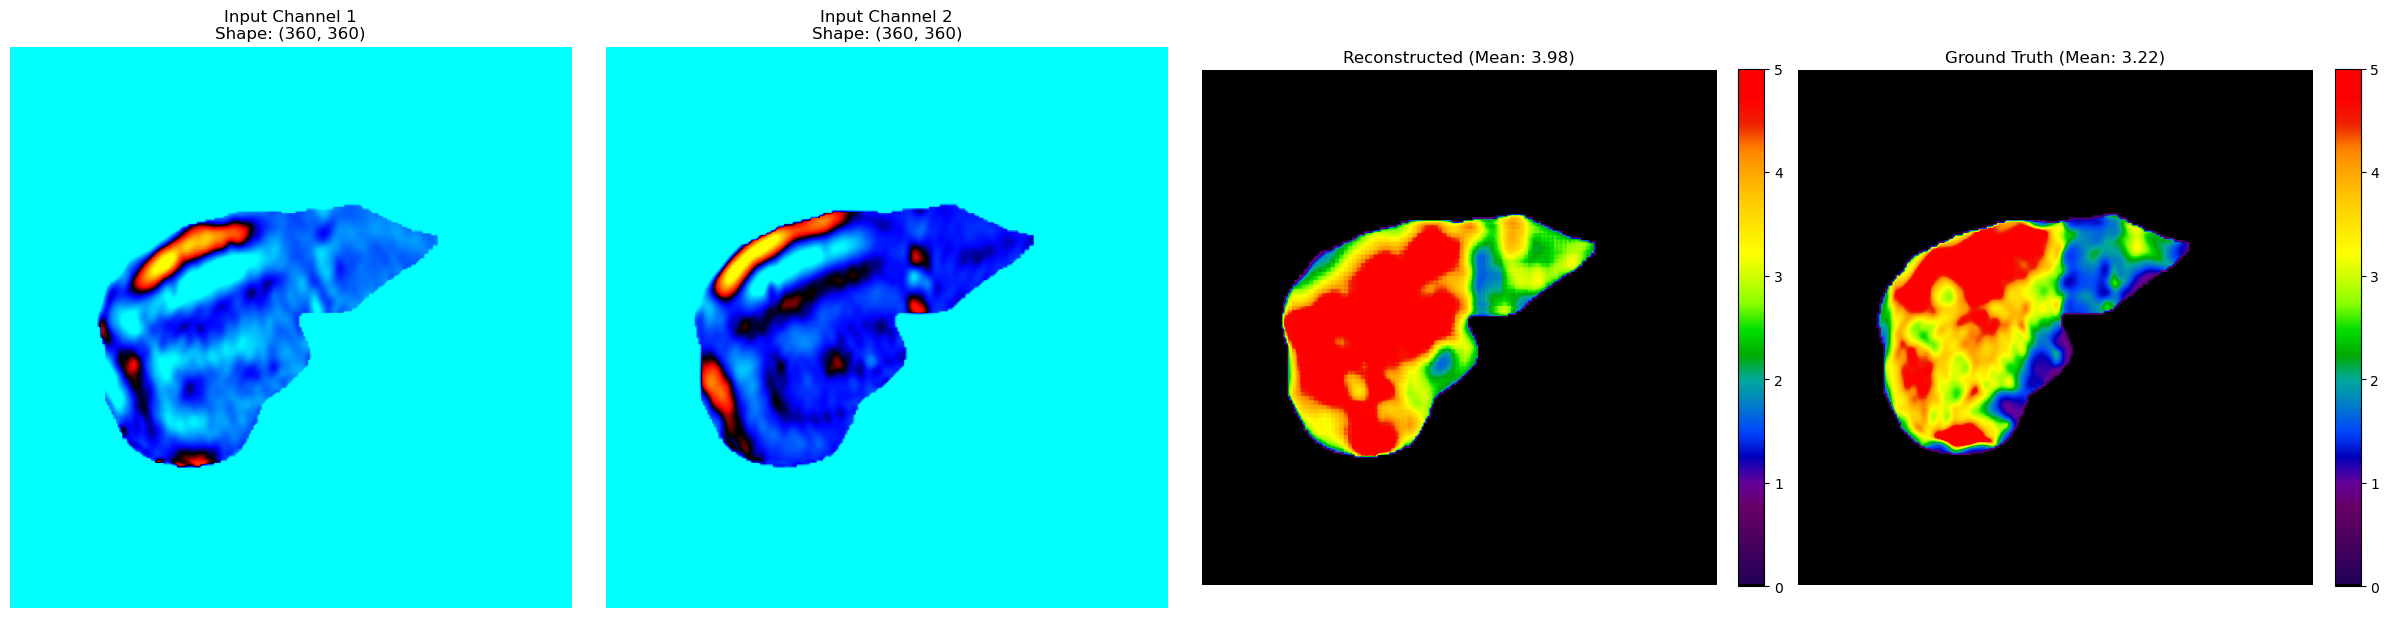

Processing file 55: 55.nii and 55.mat


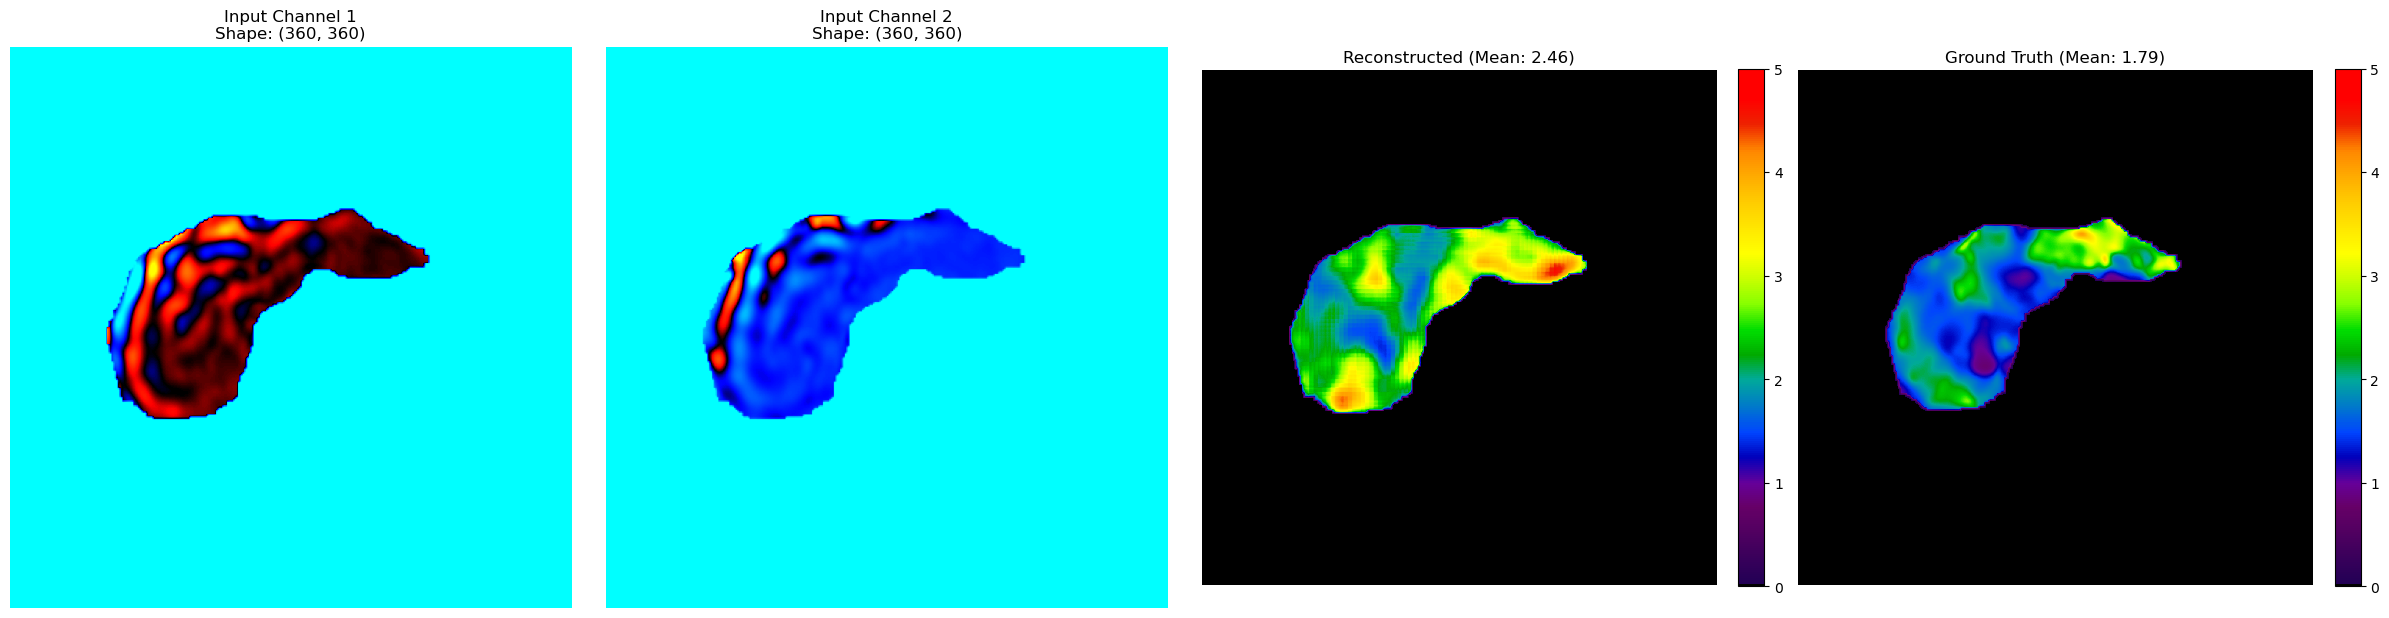

Processing file 56: 56.nii and 56.mat


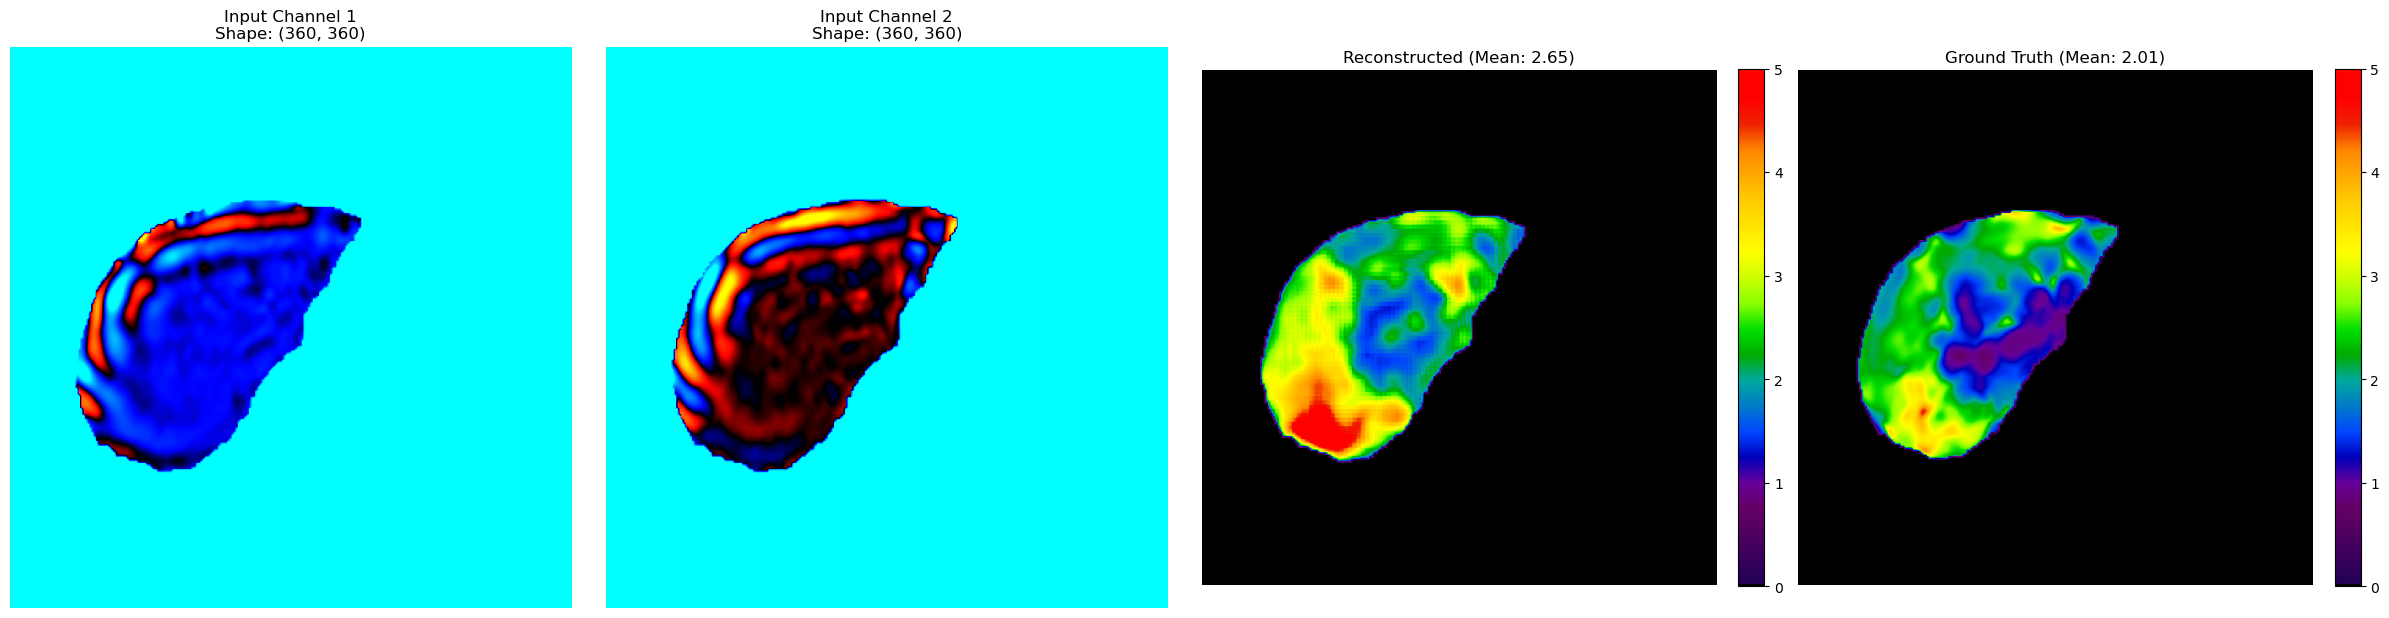

Processing file 57: 57.nii and 57.mat


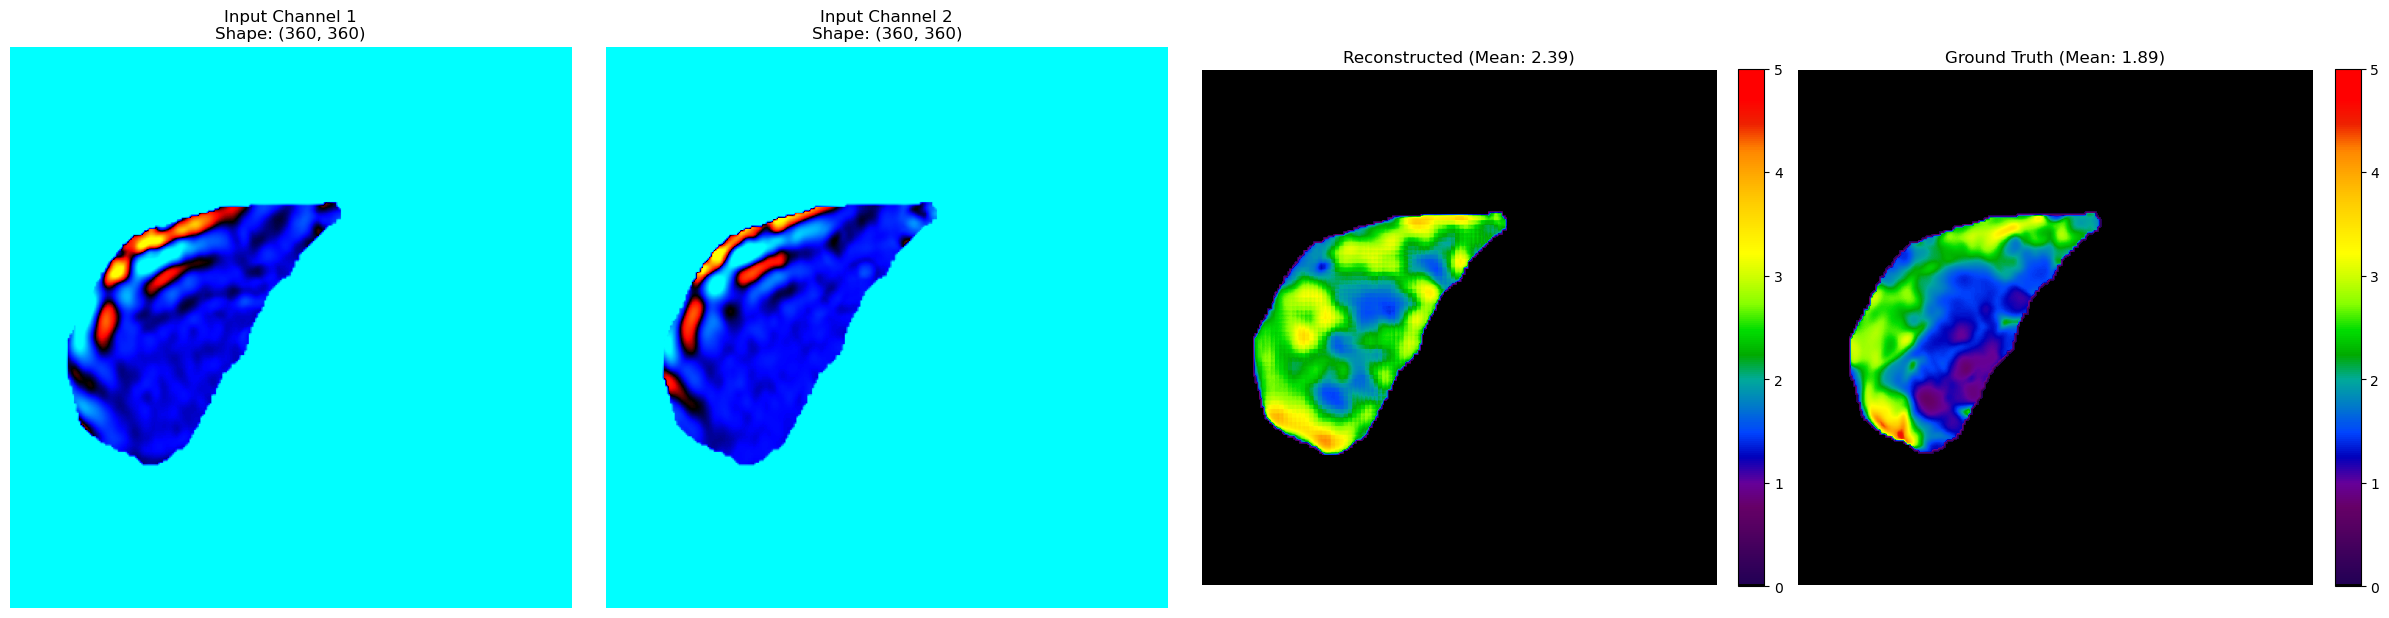

Processing file 58: 58.nii and 58.mat


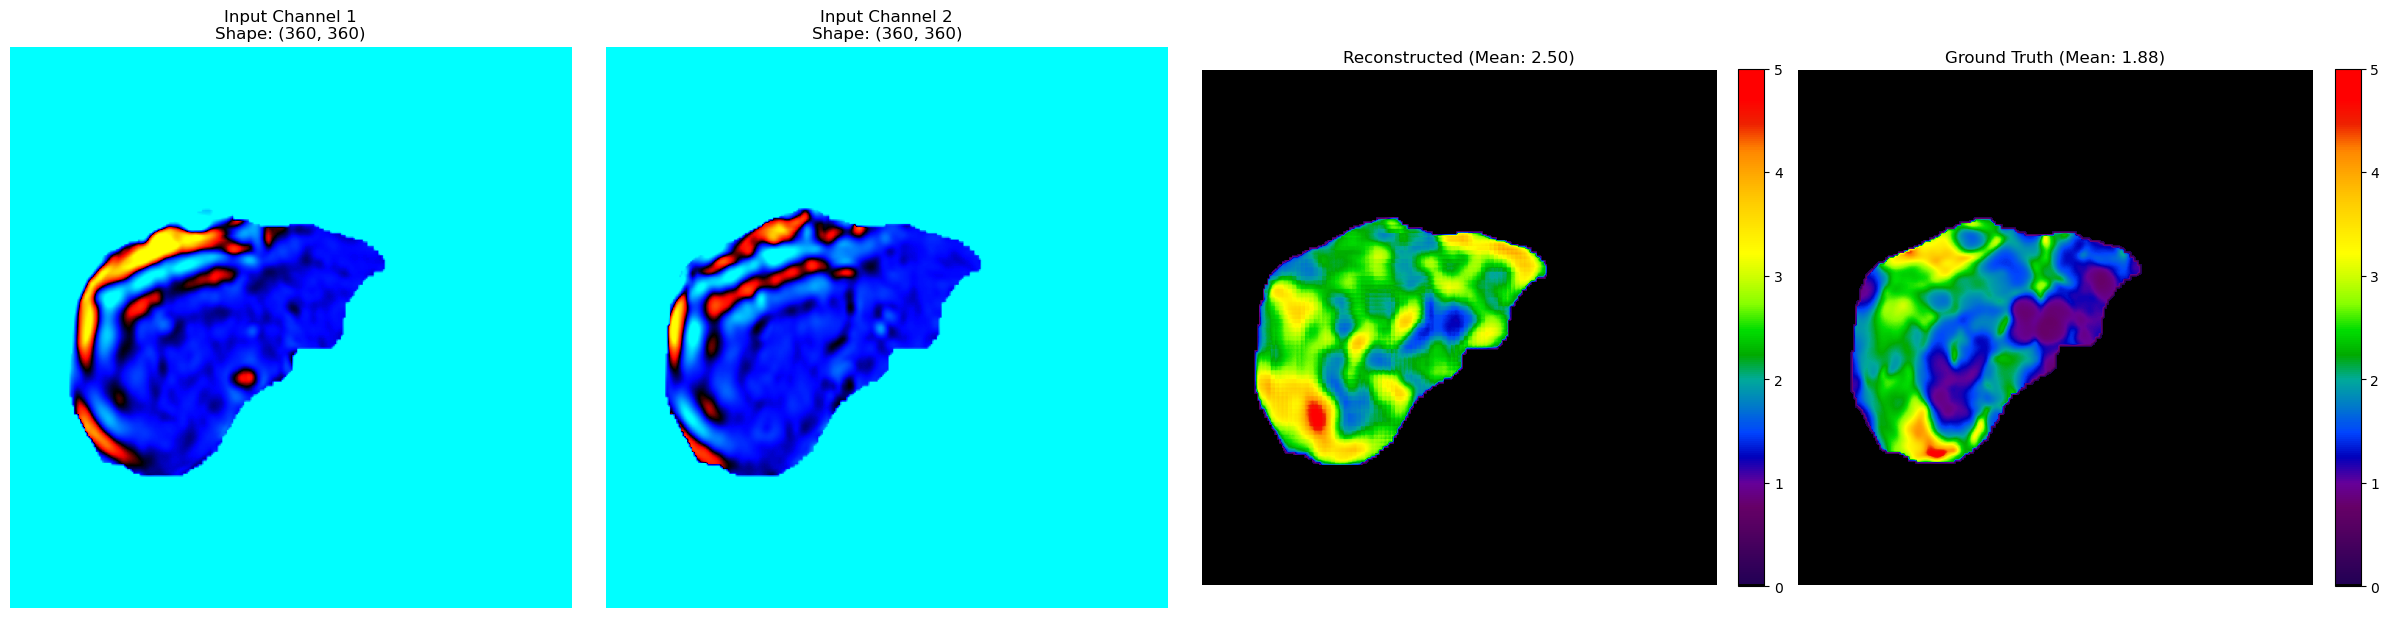

Processing file 59: 59.nii and 59.mat


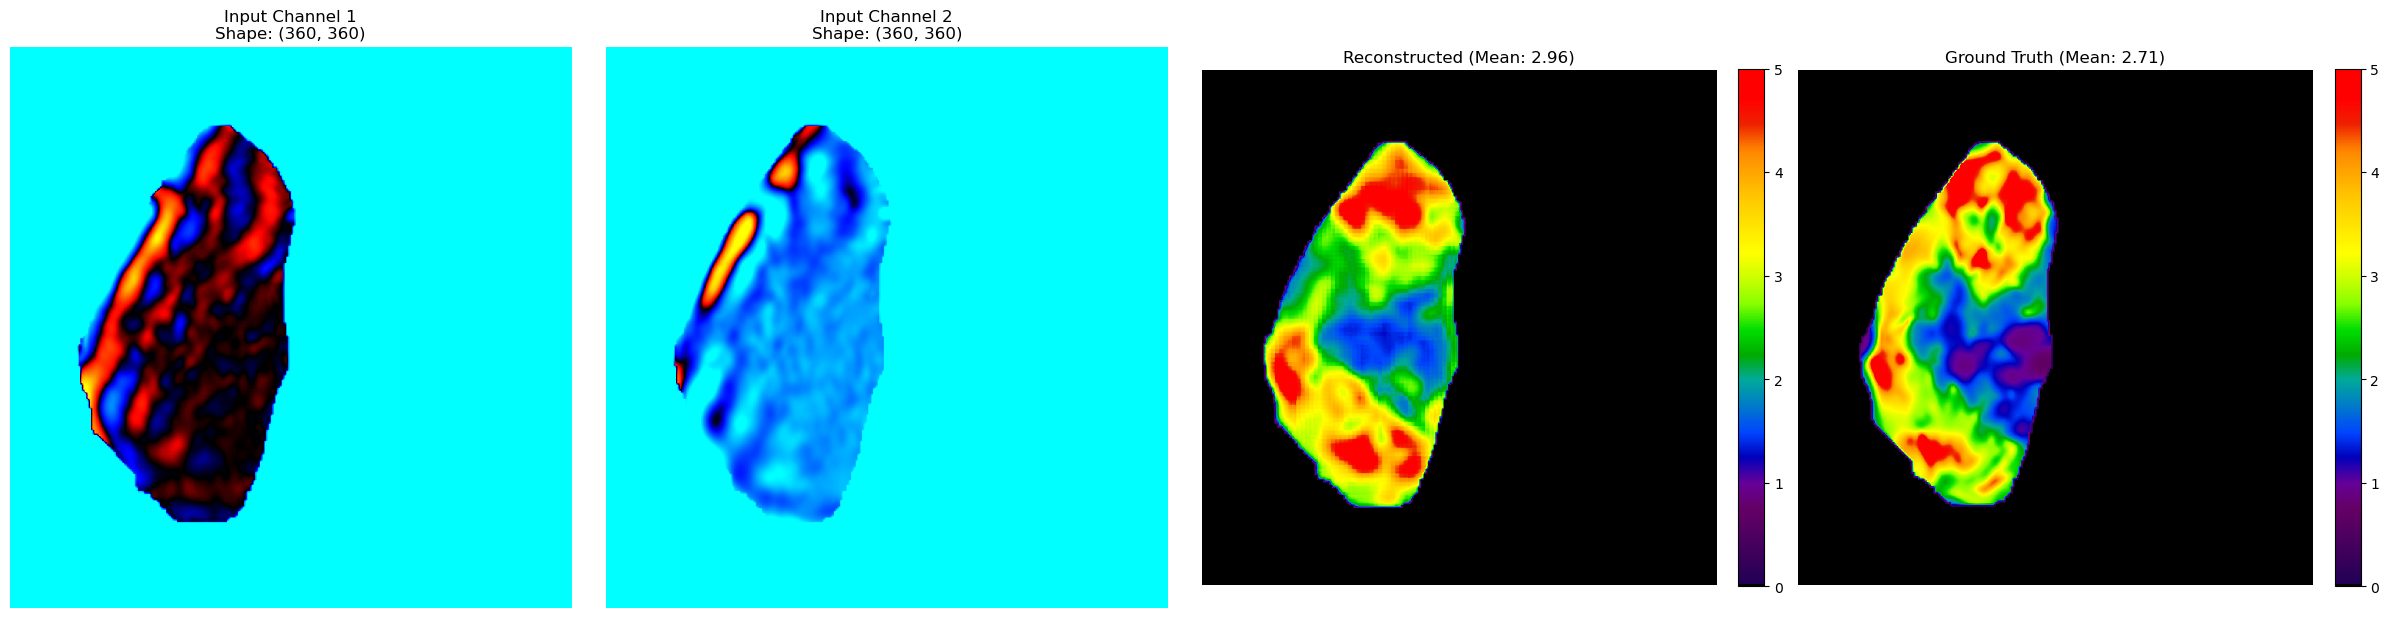

Processing file 60: 60.nii and 60.mat


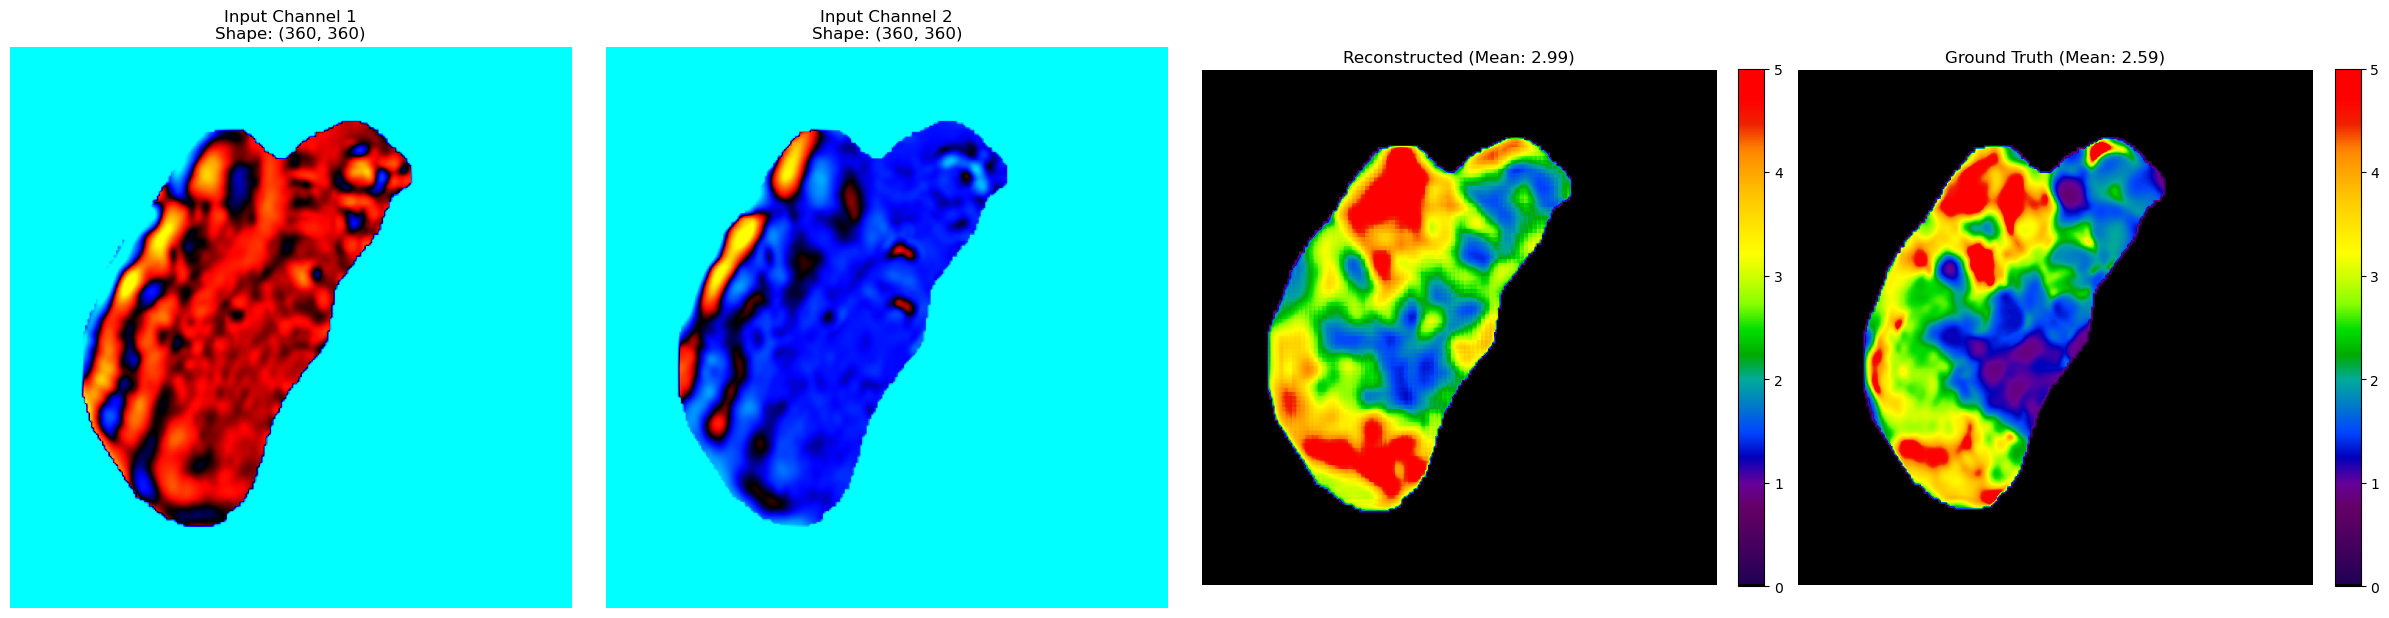

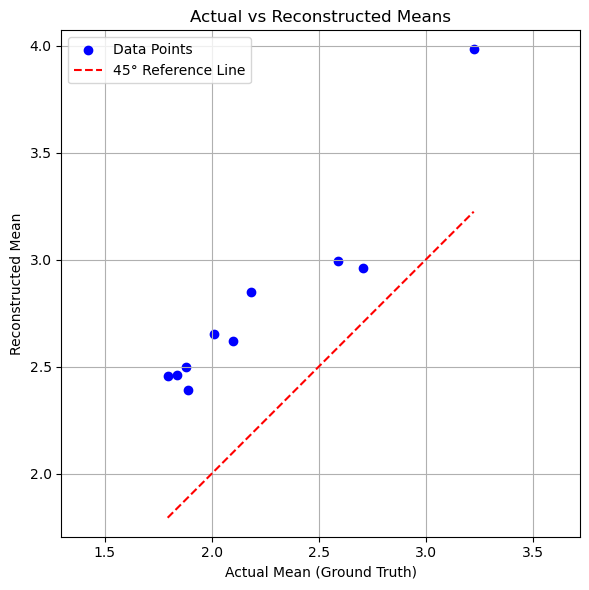


Saved results to: ./study-4_2part.xlsx


In [17]:
import os
import re
import torch
import nibabel as nib
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.metrics import r2_score
import pandas as pd  # needed for saving to Excel
from matplotlib.colors import ListedColormap

# Parameters
patch_size = 30
stride = 3
batch_size = 128
scale_factor = 1.40625  # from 1.40625 mm to 1.0 mm

# ---- Windowing controls for input displays (tunable) ----
# (These are for the first two subplots)
window_width = 3000
window_level = 2300

# ---- Separate windowing controls for AAASMO subplots (recon + gt) ----
# Set both to None to keep previous behavior (use clim from data).
# Example to enable: out_window_width = 3.0; out_window_level = 1.5
out_window_width = 5.0
out_window_level = 2.5

def apply_window_uint8(img, ww, wl):
    """
    Apply window width (WW) and window level (WL) to an image for display,
    scaling to [0,255] uint8 (for grayscale 'inputs' visualization).
    """
    lower = wl - ww / 2.0
    upper = wl + ww / 2.0
    img_w = np.clip(img, lower, upper)
    img_w = (img_w - lower) / max(upper - lower, 1e-9) * 255.0
    return img_w.astype(np.uint8)

def apply_window_clip(img, ww, wl):
    """
    Apply windowing by clipping to [lower, upper] in the *original units*
    (for color-mapped outputs). Keeps physical units so colorbar matches WL/WW.
    """
    lower = wl - ww / 2.0
    upper = wl + ww / 2.0
    return np.clip(img, lower, upper), lower, upper

def awave(m=256):
    """
    AWAVE colormap (Python port of your MATLAB awave.m).
    """
    aw_hex = [
        'ff','ff','00','ff','fc','00','ff','fa','00','ff','f7','00',
        'ff','f4','00','ff','f2','00','ff','ef','00','ff','ec','00',
        'ff','ea','00','ff','e7','00','ff','e4','00','ff','e1','00',
        'ff','df','00','ff','dc','00','ff','d9','00','ff','d7','00',
        'ff','d4','00','ff','d1','00','ff','cf','00','ff','cc','00',
        'ff','c9','00','ff','c7','00','ff','c4','00','ff','c1','00',
        'ff','bf','00','ff','bc','00','ff','b9','00','ff','b7','00',
        'ff','b4','00','ff','b1','00','ff','ae','00','ff','ac','00',
        'ff','a9','00','ff','a6','00','ff','a4','00','ff','a1','00',
        'ff','9e','00','ff','9c','00','ff','99','00','ff','96','00',
        'ff','94','00','ff','91','00','ff','8e','00','ff','8c','00',
        'ff','89','00','ff','86','00','ff','84','00','ff','81','00',
        'ff','7e','00','ff','7b','00','ff','79','00','ff','76','00',
        'ff','73','00','ff','71','00','ff','6e','00','ff','6b','00',
        'ff','69','00','ff','66','00','ff','63','00','ff','61','00',
        'ff','5e','00','ff','5b','00','ff','59','00','ff','56','00',
        'ff','53','00','ff','51','00','ff','4e','00','ff','4b','00',
        'ff','48','00','ff','46','00','ff','43','00','ff','40','00',
        'ff','3e','00','ff','3b','00','ff','38','00','ff','36','00',
        'ff','33','00','ff','30','00','ff','2e','00','ff','2b','00',
        'ff','28','00','ff','26','00','ff','23','00','ff','20','00',
        'ff','1e','00','ff','1b','00','ff','18','00','ff','15','00',
        'ff','13','00','ff','10','00','ff','0d','00','ff','0b','00',
        'ff','08','00','ff','05','00','ff','03','00','ff','00','00',
        'f7','00','00','ef','00','00','e7','00','00','df','00','00',
        'd7','00','00','cf','00','00','c7','00','00','bf','00','00',
        'b7','00','00','af','00','00','a7','00','00','9f','00','00',
        '97','00','00','8f','00','00','87','00','00','80','00','00',
        '78','00','00','70','00','00','68','00','00','60','00','00',
        '58','00','00','50','00','00','48','00','00','40','00','00',
        '38','00','00','30','00','00','28','00','00','20','00','00',
        '18','00','00','10','00','00','08','00','00','00','00','00',
        '00','00','00','00','00','08','00','00','10','00','00','18',
        '00','00','20','00','00','28','00','00','30','00','00','38',
        '00','00','40','00','00','48','00','00','50','00','00','58',
        '00','00','60','00','00','68','00','00','70','00','00','78',
        '00','00','80','00','00','87','00','00','8f','00','00','97',
        '00','00','9f','00','00','a7','00','00','af','00','00','b7',
        '00','00','bf','00','00','c7','00','00','cf','00','00','d7',
        '00','00','df','00','00','e7','00','00','ef','00','00','f7',
        '00','00','ff','00','03','ff','00','05','ff','00','08','ff',
        '00','0b','ff','00','0d','ff','00','10','ff','00','13','ff',
        '00','15','ff','00','18','ff','00','1b','ff','00','1e','ff',
        '00','20','ff','00','23','ff','00','26','ff','00','28','ff',
        '00','2b','ff','00','2e','ff','00','30','ff','00','33','ff',
        '00','36','ff','00','38','ff','00','3b','ff','00','3e','ff',
        '00','40','ff','00','43','ff','00','46','ff','00','48','ff',
        '00','4b','ff','00','4e','ff','00','51','ff','00','53','ff',
        '00','56','ff','00','59','ff','00','5b','ff','00','5e','ff',
        '00','61','ff','00','63','ff','00','66','ff','00','69','ff',
        '00','6b','ff','00','6e','ff','00','71','ff','00','73','ff',
        '00','76','ff','00','79','ff','00','7b','ff','00','7e','ff',
        '00','81','ff','00','84','ff','00','86','ff','00','89','ff',
        '00','8c','ff','00','8e','ff','00','91','ff','00','94','ff',
        '00','96','ff','00','99','ff','00','9c','ff','00','9e','ff',
        '00','a1','ff','00','a4','ff','00','a6','ff','00','a9','ff',
        '00','ac','ff','00','ae','ff','00','b1','ff','00','b4','ff',
        '00','b7','ff','00','b9','ff','00','bc','ff','00','bf','ff',
        '00','c1','ff','00','c4','ff','00','c7','ff','00','c9','ff',
        '00','cc','ff','00','cf','ff','00','d1','ff','00','d4','ff',
        '00','d7','ff','00','d9','ff','00','dc','ff','00','df','ff',
        '00','e1','ff','00','e4','ff','00','e7','ff','00','ea','ff',
        '00','ec','ff','00','ef','ff','00','f2','ff','00','f4','ff',
        '00','f7','ff','00','fa','ff','00','fc','ff','00','ff','ff'
    ]
    aw_rgb = np.array([int(v, 16) for v in aw_hex]).reshape(-1, 3) / 255.0
    aw_rgb = np.flipud(aw_rgb)  # flip like MATLAB flipdim
    idx = np.linspace(0, 255, m, dtype=int)
    aw_rgb = aw_rgb[idx]
    return ListedColormap(aw_rgb, name='awave')

def aaasmo(m=256):
    """
    Python port of your MATLAB aaasmo.m colormap.
    Robust to slightly truncated/expanded tables: resamples to 256 rows if needed.
    """
    aw_blob = """
'00'; '00'; '00'; '22'; '00'; '55'; '24'; '00'; '55'; '26'; '00'; '56'; '28'; '00'; '56'; '29'; '00'; '57'; '2b'; '00'; '57'; '2d'; '00'; '58'; '2f'; '00'; '58'; '31'; '00'; '59'; '33'; '00'; '59'; '34'; '00'; '5a'; '36'; '00'; '5a'; '38'; '00'; '5b'; '3a'; '00'; '5b'; '3c'; '00'; '5b'; '3e'; '00'; '5c'; '3f'; '00'; '5c'; '41'; '00'; '5d'; '43'; '00'; '5d'; '45'; '00'; '5e'; '47'; '00'; '5e'; '49'; '00'; '5f'; '4a'; '00'; '5f'; '4c'; '00'; '60'; '4e'; '00'; '60'; '50'; '00'; '60'; '52'; '00'; '61'; '54'; '00'; '61'; '55'; '00'; '62'; '57'; '00'; '62'; '59'; '00'; '63'; '5b'; '00'; '63'; '5d'; '00'; '64'; '5f'; '00'; '64'; '60'; '00'; '65'; '62'; '00'; '65'; '64'; '00'; '66'; '66'; '00'; '66'; '66'; '00'; '6a'; '66'; '00'; '6f'; '66'; '00'; '73'; '66'; '00'; '77'; '66'; '00'; '7b'; '66'; '00'; '80'; '66'; '00'; '84'; '66'; '00'; '88'; '66'; '00'; '8c'; '66'; '00'; '91'; '66'; '00'; '95'; '66'; '00'; '99'; '5e'; '00'; '9c'; '56'; '00'; '9e'; '4e'; '00'; 'a1'; '47'; '00'; 'a3'; '3f'; '00'; 'a6'; '37'; '00'; 'a9'; '2f'; '00'; 'ab'; '27'; '00'; 'ae'; '1f'; '00'; 'b1'; '18'; '00'; 'b3'; '10'; '00'; 'b6'; '08'; '00'; 'b8'; '00'; '00'; 'bb'; '00'; '06'; 'c1'; '00'; '0b'; 'c6'; '00'; '11'; 'cc'; '00'; '17'; 'd2'; '00'; '1c'; 'd7'; '00'; '22'; 'dd'; '00'; '28'; 'e3'; '00'; '2d'; 'e8'; '00'; '33'; 'ee'; '00'; '39'; 'f4'; '00'; '3e'; 'f9'; '00'; '44'; 'ff'; '00'; '48'; 'fb'; '00'; '4d'; 'f7'; '00'; '51'; 'f2'; '00'; '55'; 'ee'; '00'; '59'; 'ea'; '00'; '5e'; 'e6'; '00'; '62'; 'e1'; '00'; '66'; 'dd'; '00'; '6a'; 'd9'; '00'; '6f'; 'd5'; '00'; '73'; 'd0'; '00'; '77'; 'cc'; '00'; '7b'; 'c8'; '00'; '7e'; 'c5'; '00'; '82'; 'c1'; '00'; '86'; 'bd'; '00'; '89'; 'ba'; '00'; '8d'; 'b6'; '00'; '91'; 'b3'; '00'; '94'; 'af'; '00'; '98'; 'ab'; '00'; '9b'; 'a8'; '00'; '9f'; 'a4'; '00'; 'a3'; 'a0'; '00'; 'a6'; '9d'; '00'; 'aa'; '99'; '00'; 'aa'; '8c'; '00'; 'aa'; '80'; '00'; 'aa'; '73'; '00'; 'aa'; '66'; '00'; 'aa'; '59'; '00'; 'aa'; '4d'; '00'; 'aa'; '40'; '00'; 'aa'; '33'; '00'; 'aa'; '26'; '00'; 'aa'; '1a'; '00'; 'aa'; '0d'; '00'; 'aa'; '00'; '00'; 'ae'; '00'; '00'; 'b3'; '00'; '00'; 'b7'; '00'; '00'; 'bb'; '00'; '00'; 'bf'; '00'; '00'; 'c4'; '00'; '00'; 'c8'; '00'; '00'; 'cc'; '00'; '00'; 'd0'; '00'; '00'; 'd5'; '00'; '00'; 'd9'; '00'; '00'; 'dd'; '00'; '0a'; 'e0'; '00'; '15'; 'e2'; '00'; '1f'; 'e5'; '00'; '2a'; 'e7'; '00'; '34'; 'ea'; '00'; '3f'; 'ed'; '00'; '49'; 'ef'; '00'; '54'; 'f2'; '00'; '5e'; 'f5'; '00'; '69'; 'f7'; '00'; '73'; 'fa'; '00'; '7e'; 'fc'; '00'; '88'; 'ff'; '00'; '8d'; 'ff'; '00'; '92'; 'ff'; '00'; '98'; 'ff'; '00'; '9d'; 'ff'; '00'; 'a2'; 'ff'; '00'; 'a7'; 'ff'; '00'; 'ad'; 'ff'; '00'; 'b2'; 'ff'; '00'; 'b7'; 'ff'; '00'; 'bc'; 'ff'; '00'; 'c2'; 'ff'; '00'; 'c7'; 'ff'; '00'; 'cc'; 'ff'; '00'; 'd0'; 'ff'; '00'; 'd5'; 'ff'; '00'; 'd9'; 'ff'; '00'; 'dd'; 'ff'; '00'; 'e1'; 'ff'; '00'; 'e6'; 'ff'; '00'; 'ea'; 'ff'; '00'; 'ee'; 'ff'; '00'; 'f2'; 'ff'; '00'; 'f7'; 'ff'; '00'; 'fb'; 'ff'; '00'; 'ff'; 'ff'; '00'; 'ff'; 'fd'; '00'; 'ff'; 'fb'; '00'; 'ff'; 'f9'; '00'; 'ff'; 'f7'; '00'; 'ff'; 'f5'; '00'; 'ff'; 'f3'; '00'; 'ff'; 'f1'; '00'; 'ff'; 'ef'; '00'; 'ff'; 'ed'; '00'; 'ff'; 'eb'; '00'; 'ff'; 'e9'; '00'; 'ff'; 'e7'; '00'; 'ff'; 'e4'; '00'; 'ff'; 'e2'; '00'; 'ff'; 'e0'; '00'; 'ff'; 'de'; '00'; 'ff'; 'dc'; '00'; 'ff'; 'da'; '00'; 'ff'; 'd8'; '00'; 'ff'; 'd6'; '00'; 'ff'; 'd4'; '00'; 'ff'; 'd2'; '00'; 'ff'; 'd0'; '00'; 'ff'; 'ce'; '00'; 'ff'; 'cc'; '00'; 'ff'; 'c9'; '00'; 'ff'; 'c7'; '00'; 'ff'; 'c4'; '00'; 'ff'; 'c2'; '00'; 'ff'; 'bf'; '00'; 'ff'; 'bc'; '00'; 'ff'; 'ba'; '00'; 'ff'; 'b7'; '00'; 'ff'; 'b4'; '00'; 'ff'; 'b2'; '00'; 'ff'; 'af'; '00'; 'ff'; 'ad'; '00'; 'ff'; 'aa'; '00'; 'ff'; 'a7'; '00'; 'ff'; 'a4'; '00'; 'ff'; 'a2'; '00'; 'ff'; '9f'; '00'; 'ff'; '9c'; '00'; 'ff'; '99'; '00'; 'ff'; '96'; '00'; 'ff'; '93'; '00'; 'ff'; '91'; '00'; 'ff'; '8e'; '00'; 'ff'; '8b'; '00'; 'ff'; '88'; '00'; 'fe'; '80'; '00'; 'fc'; '78'; '00'; 'fb'; '70'; '00'; 'fa'; '69'; '00'; 'f8'; '61'; '00'; 'f7'; '59'; '00'; 'f6'; '51'; '00'; 'f5'; '49'; '00'; 'f3'; '41'; '00'; 'f2'; '3a'; '00'; 'f1'; '32'; '00'; 'ef'; '2a'; '00'; 'ee'; '22'; '00'; 'ef'; '1f'; '00'; 'f1'; '1c'; '00'; 'f2'; '1a'; '00'; 'f4'; '17'; '00'; 'f5'; '14'; '00'; 'f7'; '11'; '00'; 'f8'; '0e'; '00'; 'f9'; '0b'; '00'; 'fb'; '09'; '00'; 'fc'; '06'; '00'; 'fe'; '03'; '00'; 'ff'; '00'; '00'; 'ff'; '00'; '00'; 'ff'; '00'; '00'; 'ff'; '00'; '00'; 'ff'; '00'; '00'; 'ff'; '00'; '00'; 'ff'; '00'; '00'; 'ff'; '00'; '00'; 'ff'; '00'; '00'; 'ff'; '00'; '00'; 'ff'; '00'; '00'; 'ff'; '00'; '00'; 'ff'; '00'; '00'; 'ff'; '00'; '00'; 'ff'; '00'; '00'; 'ff'; '00'; '00'
    """
    tokens = re.findall(r"'([0-9A-Fa-f]{2})'", aw_blob)
    if len(tokens) % 3 != 0:
        raise ValueError(f"Malformed aaasmo hex table: {len(tokens)} tokens is not divisible by 3")
    rgb = np.array([int(t, 16) for t in tokens], dtype=np.uint8).reshape(-1, 3) / 255.0

    # Ensure exactly 256 base rows (MATLAB table length). If not, resample smoothly.
    base_n = rgb.shape[0]
    if base_n != 256:
        xp = np.linspace(0.0, 1.0, base_n)
        x = np.linspace(0.0, 1.0, 256)
        r = np.interp(x, xp, rgb[:, 0])
        g = np.interp(x, xp, rgb[:, 1])
        b = np.interp(x, xp, rgb[:, 2])
        rgb = np.stack([r, g, b], axis=1)

    # Subsample evenly to m colors if requested
    idx = np.linspace(0, 255, m, dtype=int)
    rgb = rgb[idx]
    return ListedColormap(rgb, name='aaasmo')

# Paths
data_folder = './Study3-Sample Data/Processed Data'
label_folder = './Study3-Sample Data/Processed stiffness'

# Device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('./trained_model.pth', map_location=device, weights_only=False).to(device)
model.eval()

def pad_to_360(arr):
    h, w = arr.shape
    padded = np.zeros((360, 360), dtype=arr.dtype)
    top = (360 - h) // 2
    left = (360 - w) // 2
    padded[top:top + h, left:left + w] = arr
    return padded

def process_input_fft(img_data):
    fft_result = np.fft.fft(img_data, axis=-1)
    first_harmonic = fft_result[..., 1]
    real = np.real(first_harmonic)
    imag = np.imag(first_harmonic)

    real_mask = real != 0
    if np.any(real_mask):
        real_min = real[real_mask].min()
        real_max = real[real_mask].max()
        if real_max > real_min:
            real[real_mask] = (real[real_mask] - real_min) / (real_max - real_min) * 4095

    imag_mask = imag != 0
    if np.any(imag_mask):
        imag_min = imag[imag_mask].min()
        imag_max = imag[imag_mask].max()
        if imag_max > imag_min:
            imag[imag_mask] = (imag[imag_mask] - imag_min) / (imag_max - imag_min) * 4095

    return np.stack([real, imag], axis=0)

def patch_based_batch_inference(input_tensor):
    c, h, w = input_tensor.shape
    recon = torch.zeros((1, 1, h, w), dtype=torch.float32, device=device)
    count = torch.zeros_like(recon)

    patch_list, mask_list, loc_list = [], [], []

    for i in range(0, h - patch_size + 1, stride):
        for j in range(0, w - patch_size + 1, stride):
            patch = input_tensor[:, i:i+patch_size, j:j+patch_size]
            if not patch.any():
                continue
            patch_tensor = torch.from_numpy(patch).float()
            mask_tensor = torch.from_numpy((patch != 0).any(axis=0).astype(np.float32))
            patch_list.append(patch_tensor)
            mask_list.append(mask_tensor)
            loc_list.append((i, j))

            if len(patch_list) == batch_size:
                _process_batch(patch_list, mask_list, loc_list, recon, count)
                patch_list, mask_list, loc_list = [], [], []

    if patch_list:
        _process_batch(patch_list, mask_list, loc_list, recon, count)

    count[count == 0] = 1
    return (recon / count).squeeze().cpu().numpy()

def _process_batch(patches, masks, locations, recon, count):
    batch_tensor = torch.stack(patches).to(device)
    masks = torch.stack(masks).to(device)
    with torch.no_grad():
        preds = model(batch_tensor)
    for k, (x, y) in enumerate(locations):
        m = masks[k].unsqueeze(0).unsqueeze(0)
        recon[:, :, x:x+patch_size, y:y+patch_size] += preds[k] * m
        count[:, :, x:x+patch_size, y:y+patch_size] += m

# File selection
nii_files_all = sorted([f for f in os.listdir(data_folder) if f.endswith('.nii')], key=lambda x: int(x.split('.')[0]))
mat_files_all = sorted([f for f in os.listdir(label_folder) if f.endswith('.mat')], key=lambda x: int(x.split('.')[0]))

# Define specific file indices you want to process
file_indices = list(range(51, 61))  # change this to select desired files

# Filter selected files
nii_files = [f"{i}.nii" for i in file_indices]
mat_files = [f"{i}.mat" for i in file_indices]


# Track means
actual_means = []
recon_means = []

# Main loop
for idx, (nii_file, mat_file) in enumerate(zip(nii_files, mat_files)):
    print(f'Processing file {file_indices[idx]}: {nii_file} and {mat_file}')

    nii_img = nib.load(os.path.join(data_folder, nii_file)).get_fdata()
    nii_img = np.stack([np.rot90(np.fliplr(nii_img[:, :, i]), k=1) for i in range(nii_img.shape[-1])], axis=-1)
    input_array = process_input_fft(nii_img)

    input_tensor = torch.from_numpy(input_array).unsqueeze(0)
    input_tensor = torch.nn.functional.interpolate(
        input_tensor, scale_factor=scale_factor, mode='bilinear', align_corners=False
    )
    input_array = input_tensor.squeeze(0).numpy()

    gt = sio.loadmat(os.path.join(label_folder, mat_file))['stiff'] / 100
    gt = zoom(gt, zoom=scale_factor, order=1)
    if gt.shape != (360, 360):
        gt = pad_to_360(gt)

    recon = patch_based_batch_inference(input_array)

    recon_nonzero_mean = recon[recon != 0].mean()
    gt_nonzero_mean = gt[gt != 0].mean()
    recon_means.append(recon_nonzero_mean)
    actual_means.append(gt_nonzero_mean)

    clim = (min(gt.min(), recon.min()), max(gt.max(), recon.max()))

    fig, axes = plt.subplots(1, 4, figsize=(24, 6))

    # ---- First two subplots: windowed inputs with AWAVE colormap ----
    axes[0].imshow(apply_window_uint8(input_array[0], window_width, window_level), cmap=awave())
    axes[0].set_title(f'Input Channel 1\nShape: {input_array[0].shape}')

    axes[1].imshow(apply_window_uint8(input_array[1], window_width, window_level), cmap=awave())
    axes[1].set_title(f'Input Channel 2\nShape: {input_array[1].shape}')
    # -----------------------------------------------------------------

    # ---- Last two subplots: AAASMO colormap with optional separate WL/WW ----
    if out_window_width is None or out_window_level is None:
        # Original behavior: no explicit WL/WW on outputs
        im2 = axes[2].imshow(recon, cmap=aaasmo(), vmin=clim[0], vmax=clim[1])
        axes[2].set_title(f'Reconstructed (Mean: {recon_nonzero_mean:.2f})')
        plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

        im3 = axes[3].imshow(gt, cmap=aaasmo(), vmin=clim[0], vmax=clim[1])
        axes[3].set_title(f'Ground Truth (Mean: {gt_nonzero_mean:.2f})')
        plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)
    else:
        # Apply separate WL/WW to outputs (keeps physical units on colorbar)
        recon_w, lower, upper = apply_window_clip(recon, out_window_width, out_window_level)
        gt_w, _, _ = apply_window_clip(gt, out_window_width, out_window_level)

        im2 = axes[2].imshow(recon_w, cmap=aaasmo(), vmin=lower, vmax=upper)
        axes[2].set_title(f'Reconstructed (Mean: {recon_nonzero_mean:.2f})')
        plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

        im3 = axes[3].imshow(gt_w, cmap=aaasmo(), vmin=lower, vmax=upper)
        axes[3].set_title(f'Ground Truth (Mean: {gt_nonzero_mean:.2f})')
        plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)
    # -------------------------------------------------------------------------

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Final scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(actual_means, recon_means, color='blue', label='Data Points')
plt.plot([min(actual_means), max(actual_means)],
         [min(actual_means), max(actual_means)],
         color='red', linestyle='--', label='45° Reference Line')
plt.xlabel('Actual Mean (Ground Truth)')
plt.ylabel('Reconstructed Mean')
plt.title('Actual vs Reconstructed Means')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()

# Save to Excel
df = pd.DataFrame({
    'MMDI Mean': actual_means,
    'DIME Mean': recon_means
})
excel_output_path = './study-4_2part.xlsx'
df.to_excel(excel_output_path, index=False)
print(f"\nSaved results to: {excel_output_path}")
